In [33]:
import pandas as pd
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# import ants
import sys
import json
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.gridspec as gridspec

from dataframe_help import add_temperature_w0, calc_contrast

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
sites = ['P0029']

In [116]:
# Load data
df_par = pd.read_csv('../data/session_params.csv').drop(columns=['Unnamed: 0'])
df = pd.read_csv('../data/PSNR_df.csv').drop(columns=['index'])

df = add_temperature_w0(df, '../data/')
df = df.drop(df[df['PSNR'] == np.inf].index).reset_index()
df['mod_PSNR'] = 10**(df['PSNR']/10)

df['Date'] = pd.to_datetime(df['Session'].str[:8], format='%Y%m%d')

df = df[df.Subject.isin(sites)]

df['RelPSNR'] = 100*(df.PSNR - df.PSNR.mean())/df.PSNR.mean()

Adding in temperature and w0: 100%|██████████| 242/242 [00:00<00:00, 2780.97it/s]


In [122]:
contrast_references = {'Adult':
                        {
                            'WM': {'Seg':'T2', 'LabelValue':9},
                            'GM': {'Seg':'T2', 'LabelValue':8}
                        },
                        'Neo':
                        {
                            'WM':{'Seg':'T2', 'LabelValue':4},
                            'GM': {'Seg':'T2', 'LabelValue':8}
                        }
                    }

df_con = pd.read_csv('../data/contrast_df.csv')

df_con = calc_contrast(df_con, contrast_references)
df_con = add_temperature_w0(df_con, '../data')
df_con['Date'] = pd.to_datetime(df_con['Session'].str[:8], format='%Y%m%d')

df_con = df_con[df_con.Subject.isin(sites)]

df_con['RelNeo'] = 100*(df_con['Neonatal WM/GM Contrast'] - df_con['Neonatal WM/GM Contrast'].mean())/df_con['Neonatal WM/GM Contrast'].mean()
df_con['RelAdult'] = 100*(df_con['Adult WM/GM Contrast'] - df_con['Adult WM/GM Contrast'].mean())/df_con['Adult WM/GM Contrast'].mean()

Adding in temperature and w0: 100%|██████████| 242/242 [00:00<00:00, 2737.52it/s]


In [129]:
df_scale = pd.read_csv('../data/distortions_scale_df.csv')
df_scale['Date'] = pd.to_datetime(df_scale['Session'].str[:8], format='%Y%m%d')
df_scale = df_scale[(df_scale.Subject.isin(sites)) & (df_scale.Axis == 'axi')]
df_scale['Plate'] = df_scale.Plate.astype(str)

df_scale['ScaleRel'] = 100*(df_scale.S - df_scale.S.mean())/df_scale.S.mean()
df_scale['rxyRel'] = 100*(df_scale.rxy - df_scale.rxy.mean())/(df_scale.rxy.mean()+1)

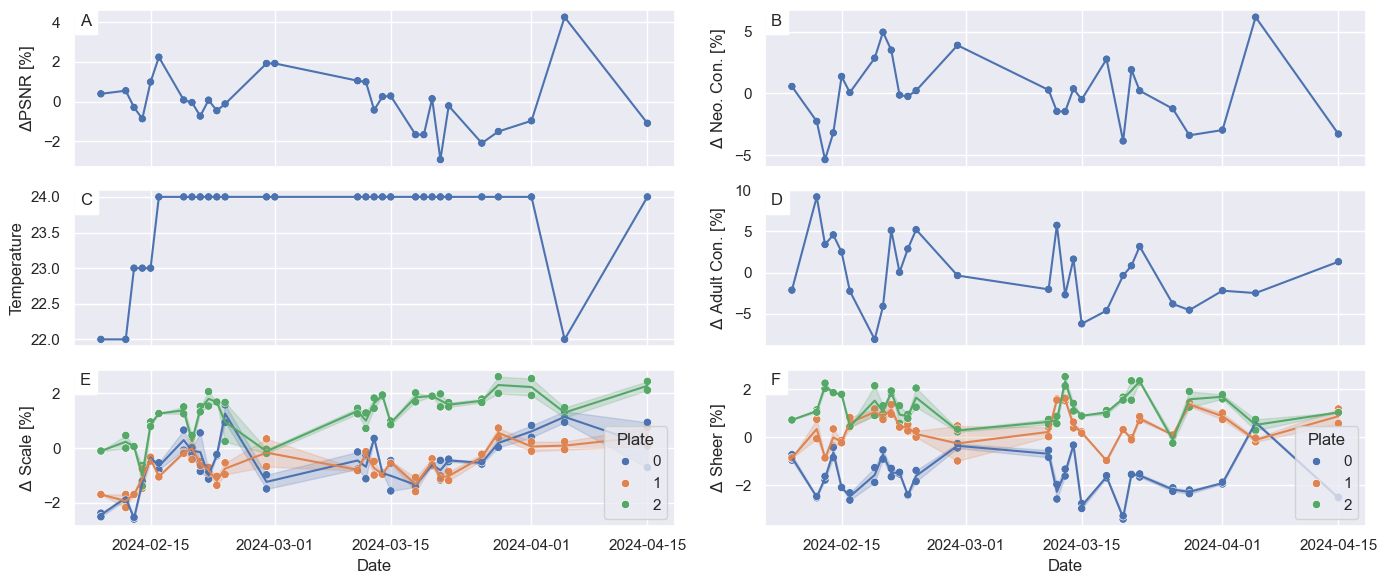

In [131]:
def add_letter(ax, fx, fy, my_string):
    y0,y1 = ax.get_ylim()
    y = y1 - (y1-y0)*fy
    # y = y0
    ax.text(ax.get_xlim()[0]*(1+fx), y, my_string, backgroundcolor='w')

sns.set_theme()
fig, axes = plt.subplots(3,2, figsize=(14,6))

# PSNR
sns.scatterplot(data=df, x='Date', y='RelPSNR', hue='Subject', ax=axes[0,0], legend=None)
sns.lineplot(data=df, x='Date', y='RelPSNR', hue='Subject', ax=axes[0,0], legend=None)
axes[0,0].set_ylabel(r'$\Delta$PSNR [%]')

# Temperature
sns.scatterplot(data=df, x='Date', y='Temperature', hue='Subject', ax=axes[1,0], legend=None)
sns.lineplot(data=df, x='Date', y='Temperature', hue='Subject', ax=axes[1,0], legend=None)

# Neo contrast
sns.scatterplot(data=df_con[df_con['Subject'].isin(sites)], x='Date', y='RelNeo', hue='Subject', ax=axes[0,1], legend=None)
sns.lineplot(data=df_con[df_con['Subject'].isin(sites)], x='Date', y='RelNeo', hue='Subject', ax=axes[0,1], legend=None)
axes[0,1].set_ylabel(r'$\Delta$ Neo. Con. [%]')

# Neo contrast
sns.scatterplot(data=df_con[df_con['Subject'].isin(sites)], x='Date', y='RelAdult', hue='Subject', ax=axes[1,1], legend=None)
sns.lineplot(data=df_con[df_con['Subject'].isin(sites)], x='Date', y='RelAdult', hue='Subject', ax=axes[1,1], legend=None)
axes[1,1].set_ylabel(r'$\Delta$ Adult Con. [%]')

# Scale
sns.scatterplot(data=df_scale, x='Date', y='ScaleRel', hue='Plate', ax=axes[2,0])
sns.lineplot(data=df_scale, x='Date', y='ScaleRel', hue='Plate', ax=axes[2,0], legend=None)
axes[2,0].set_ylabel(r'$\Delta$ Scale [%]')

# Sheer
# Scale
sns.scatterplot(data=df_scale, x='Date', y='rxyRel', hue='Plate', ax=axes[2,1])
sns.lineplot(data=df_scale, x='Date', y='rxyRel', hue='Plate', ax=axes[2,1], legend=None)
axes[2,1].set_ylabel(r'$\Delta$ Sheer [%]')

axes[0,0].set_xlabel(None); axes[0,0].set_xticklabels([])
axes[0,1].set_xlabel(None); axes[0,1].set_xticklabels([])
axes[1,0].set_xlabel(None); axes[1,0].set_xticklabels([])
axes[1,1].set_xlabel(None); axes[1,1].set_xticklabels([])

add_letter(axes[0,0], 0.4E-4, 1E-1, 'A')
add_letter(axes[0,1], 0.4E-4, 1E-1, 'B')
add_letter(axes[1,0], 0.4E-4, 1E-1, 'C')
add_letter(axes[1,1], 0.4E-4, 1E-1, 'D')
add_letter(axes[2,0], 0.4E-4, 1E-1, 'E')
add_letter(axes[2,1], 0.4E-4, 1E-1, 'F')

# axes[0,0].text(axes[0,0].get_xlim()[0]*1.01, , 'test')

plt.tight_layout()
plt.show()

In [128]:
df_scale

,Subject,Session,Axis,Run,Plate,S,rxy,Date,ScaleRel,rxyRel
1198,P0029,20240209102454,axi,1.0,0,-1.009010,-0.016914,2024-02-09,-2.373888,127.682694
1199,P0029,20240209102454,axi,1.0,1,-1.016068,-0.015998,2024-02-09,-1.690965,115.348415
1200,P0029,20240209102454,axi,1.0,2,-1.032452,-0.000254,2024-02-09,-0.105735,-96.581771
1201,P0029,20240209102454,axi,2.0,0,-1.007649,-0.014629,2024-02-09,-2.505514,96.914779
1202,P0029,20240209102454,axi,2.0,1,-1.016068,-0.015998,2024-02-09,-1.690965,115.348415
...,...,...,...,...,...,...,...,...,...,...
1407,P0029,20240415101749,axi,1.0,1,-1.041425,-0.001717,2024-04-15,0.762470,-76.886900
1408,P0029,20240415101749,axi,1.0,2,-1.055401,0.002944,2024-04-15,2.114654,-139.624111
1409,P0029,20240415101749,axi,2.0,0,-1.043259,-0.032303,2024-04-15,0.939832,334.823781
1410,P0029,20240415101749,axi,2.0,1,-1.034351,0.004323,2024-04-15,0.077938,-158.192386
